In [1]:
# =========== IMPORT LIBRARIES ===========

#install.packages(c("MCMCpack","ggplot2","gridExtra","corrplot))
library(MCMCpack)
library(ggplot2)
library(gridExtra)
library(corrplot)
library(RColorBrewer)


Loading required package: coda

Loading required package: MASS

##
## Markov Chain Monte Carlo Package (MCMCpack)

## Copyright (C) 2003-2024 Andrew D. Martin, Kevin M. Quinn, and Jong Hee Park

##
## Support provided by the U.S. National Science Foundation

## (Grants SES-0350646 and SES-0350613)
##



In [2]:
# =========== READ DATA ===========
housing <- read.csv("data/housing.csv")

# convert variables
housing$ocean_proximity = factor(housing$ocean_proximity)
levels(housing$ocean_proximity)

# look at the data
head(housing)
dim(housing)
summary(housing)

[1] "<1H OCEAN"  "INLAND"     "ISLAND"     "NEAR BAY"   "NEAR OCEAN"

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY
2,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY
3,-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY
4,-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY
5,-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY
6,-122.25,37.85,52,919,213,413,193,4.0368,269700,NEAR BAY


[1] 20640    10

   longitude         latitude     housing_median_age  total_rooms   
 Min.   :-124.3   Min.   :32.54   Min.   : 1.00      Min.   :    2  
 1st Qu.:-121.8   1st Qu.:33.93   1st Qu.:18.00      1st Qu.: 1448  
 Median :-118.5   Median :34.26   Median :29.00      Median : 2127  
 Mean   :-119.6   Mean   :35.63   Mean   :28.64      Mean   : 2636  
 3rd Qu.:-118.0   3rd Qu.:37.71   3rd Qu.:37.00      3rd Qu.: 3148  
 Max.   :-114.3   Max.   :41.95   Max.   :52.00      Max.   :39320  
                                                                    
 total_bedrooms     population      households     median_income    
 Min.   :   1.0   Min.   :    3   Min.   :   1.0   Min.   : 0.4999  
 1st Qu.: 296.0   1st Qu.:  787   1st Qu.: 280.0   1st Qu.: 2.5634  
 Median : 435.0   Median : 1166   Median : 409.0   Median : 3.5348  
 Mean   : 537.9   Mean   : 1425   Mean   : 499.5   Mean   : 3.8707  
 3rd Qu.: 647.0   3rd Qu.: 1725   3rd Qu.: 605.0   3rd Qu.: 4.7432  
 Max.   :6445.0   Max.   :35682   

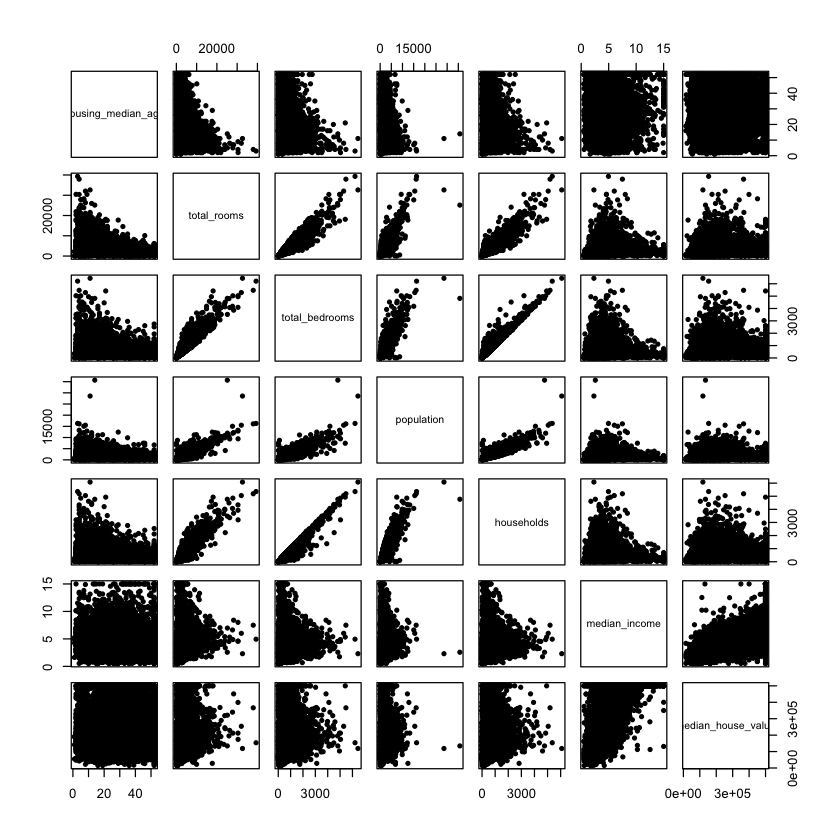

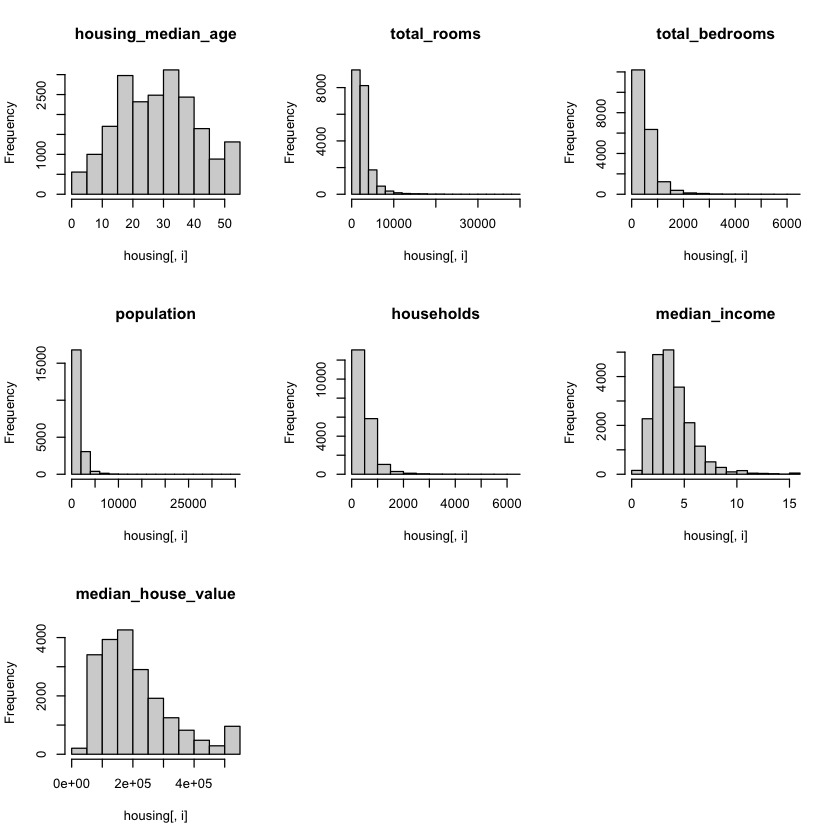

In [6]:
# =========== EXPLORATORY ANALYSIS ===========
# DROP NA (we should maybe interpolate :) )
housing <- na.omit(housing)
# PLOTS
plot(housing[,3:9], pch=20)

# HISTOGRAMS
par(mfrow=c(3,3))
for(i in 3:9)
  hist(housing[,i], main=names(housing)[i])

# Create the correlation matrix
cor_matrix <- cor(housing[,3:9])
# Plot the correlation matrix
corrplot(cor_matrix, method = "color", col =  colorRampPalette(brewer.pal(9, "YlOrRd"))(200), insig = "blank", type = "upper", addCoef.col = "black", number.cex = 0.9,outline = TRUE)


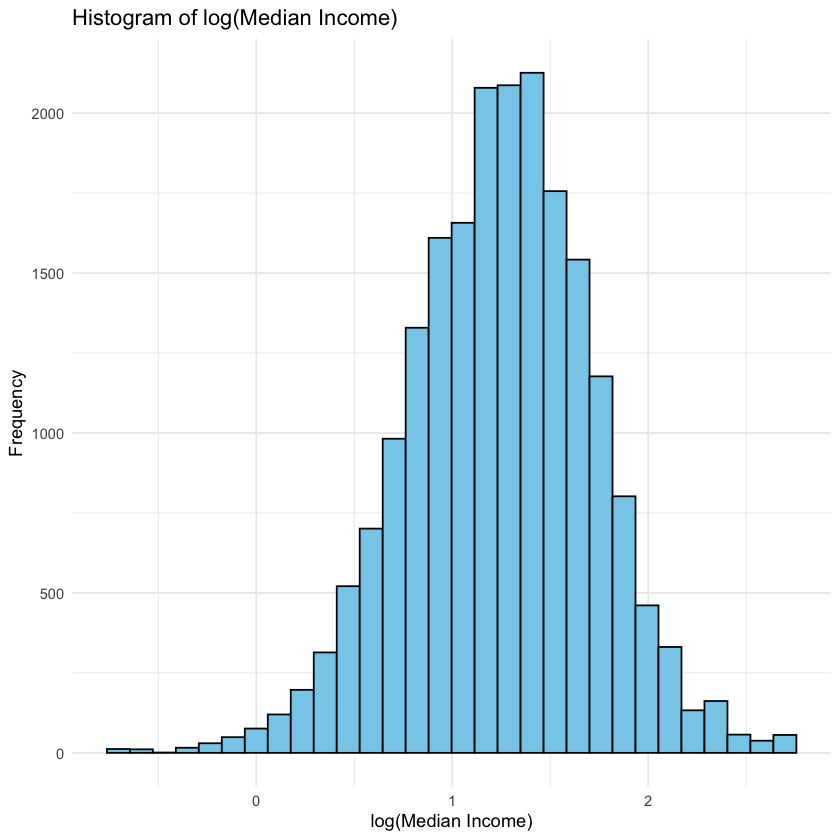

In [56]:
# =========== LOG TRANSFORMATION ===========
housing$lincome <- log(housing$median_income)

# Plot histogram with ggplot2
ggplot(housing, aes(x = lincome)) +
  geom_histogram(fill = "skyblue", color = "black", bins = 30) +
  labs(title = "Histogram of log(Median Income)", x = "log(Median Income)", y = "Frequency") +
  theme_minimal()

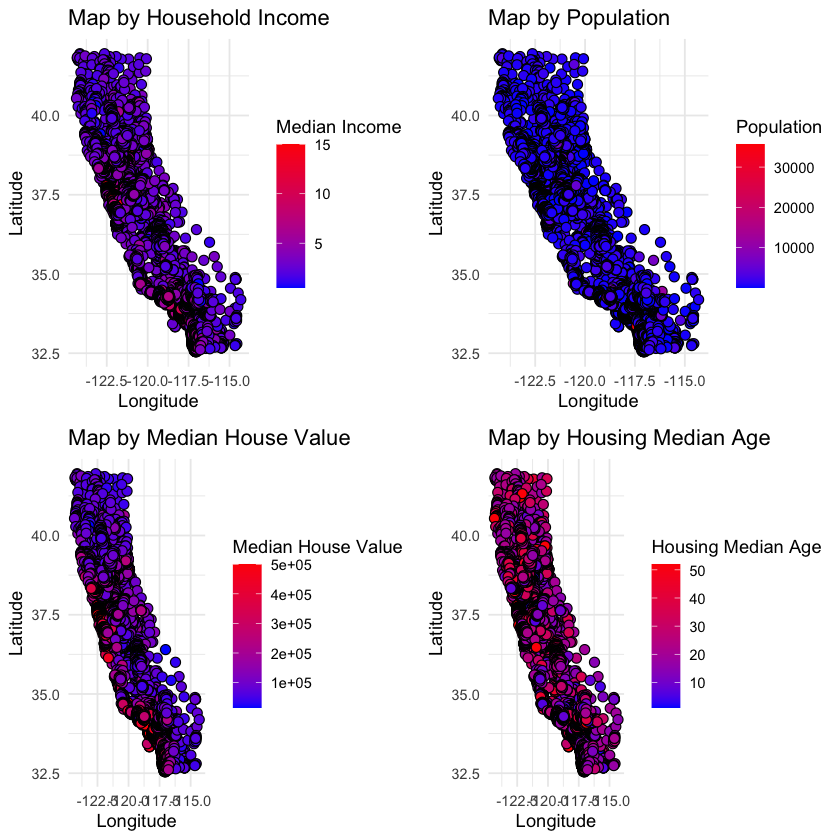

In [54]:
# Plot 1: Household Income
plot_income <- ggplot(housing, aes(x = longitude, y = latitude, fill = median_income)) +
  geom_point(shape = 21, size = 2.5) +
  labs(title = "Map by Household Income", x = "Longitude", y = "Latitude", fill = "Median Income") +
  scale_fill_gradient(low = "blue", high = "red") +
  theme_minimal() +
  theme(legend.position = "right")

# Plot 2: Population
plot_population <- ggplot(housing, aes(x = longitude, y = latitude, fill = population)) +
  geom_point(shape = 21, size = 2.5) +
  labs(title = "Map by Population", x = "Longitude", y = "Latitude", fill = "Population") +
  scale_fill_gradient(low = "blue", high = "red") +
  theme_minimal() +
  theme(legend.position = "right")

# Plot 3: Median House Value
plot_house_value <- ggplot(housing, aes(x = longitude, y = latitude, fill = median_house_value)) +
  geom_point(shape = 21, size = 2.5) +
  labs(title = "Map by Median House Value", x = "Longitude", y = "Latitude", fill = "Median House Value") +
  scale_fill_gradient(low = "blue", high = "red") +
  theme_minimal() +
  theme(legend.position = "right")

# Plot 4: Housing Median Age
plot_housing_age <- ggplot(housing, aes(x = longitude, y = latitude, fill = housing_median_age)) +
  geom_point(shape = 21, size = 2.5) +
  labs(title = "Map by Housing Median Age", x = "Longitude", y = "Latitude", fill = "Housing Median Age") +
  scale_fill_gradient(low = "blue", high = "red") +
  theme_minimal() +
  theme(legend.position = "right")

# Combine plots into a 2x2 grid
grid.arrange(plot_income, plot_population, plot_house_value, plot_housing_age, ncol = 2)


In [64]:
# SUBESET DATA WE WILL USE
data <- housing[c('housing_median_age', 'total_rooms', 'total_bedrooms', 
                             'population', 'households', 'median_house_value', 
                             'ocean_proximity', 'lincome')]


Call:
lm(formula = lincome ~ ., data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.55300 -0.14741  0.03645  0.18518  1.73107 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                1.015e+00  9.049e-03 112.140  < 2e-16 ***
housing_median_age        -5.956e-03  1.831e-04 -32.530  < 2e-16 ***
total_rooms                2.385e-04  2.880e-06  82.817  < 2e-16 ***
total_bedrooms            -1.412e-03  2.717e-05 -51.983  < 2e-16 ***
population                -2.733e-05  4.644e-06  -5.884 4.07e-09 ***
households                 3.002e-04  3.114e-05   9.641  < 2e-16 ***
median_house_value         2.211e-06  2.233e-08  99.005  < 2e-16 ***
ocean_proximityINLAND     -7.415e-02  5.583e-03 -13.283  < 2e-16 ***
ocean_proximityISLAND     -4.509e-01  1.298e-01  -3.474 0.000513 ***
ocean_proximityNEAR BAY   -2.414e-02  7.036e-03  -3.431 0.000603 ***
ocean_proximityNEAR OCEAN -8.354e-02  6.450e-03 -12.952  < 2e-16 ***
---
Sig

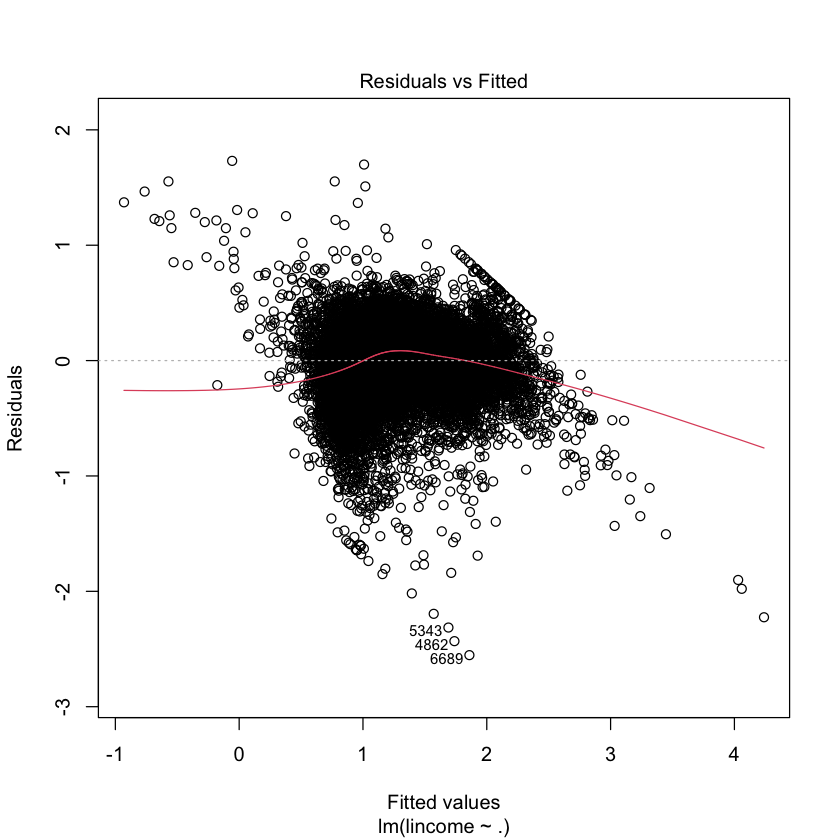

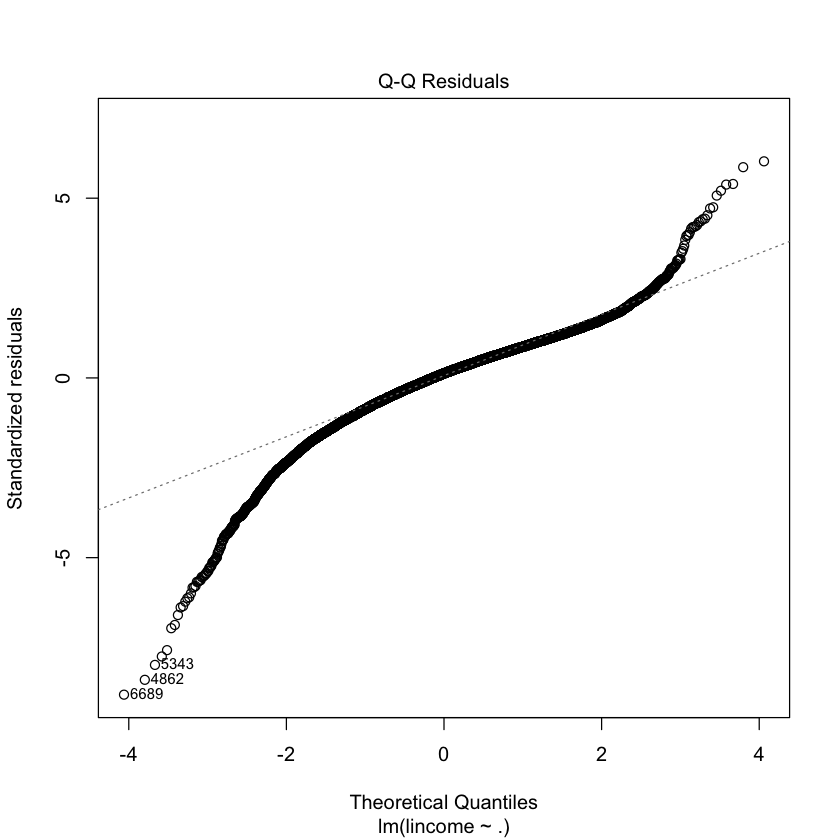

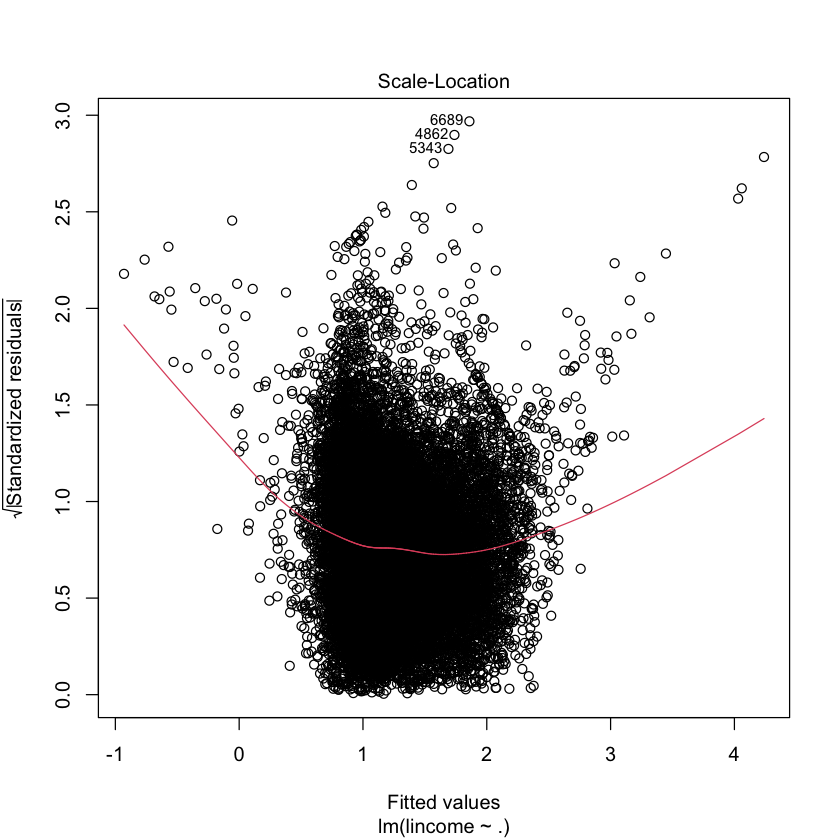

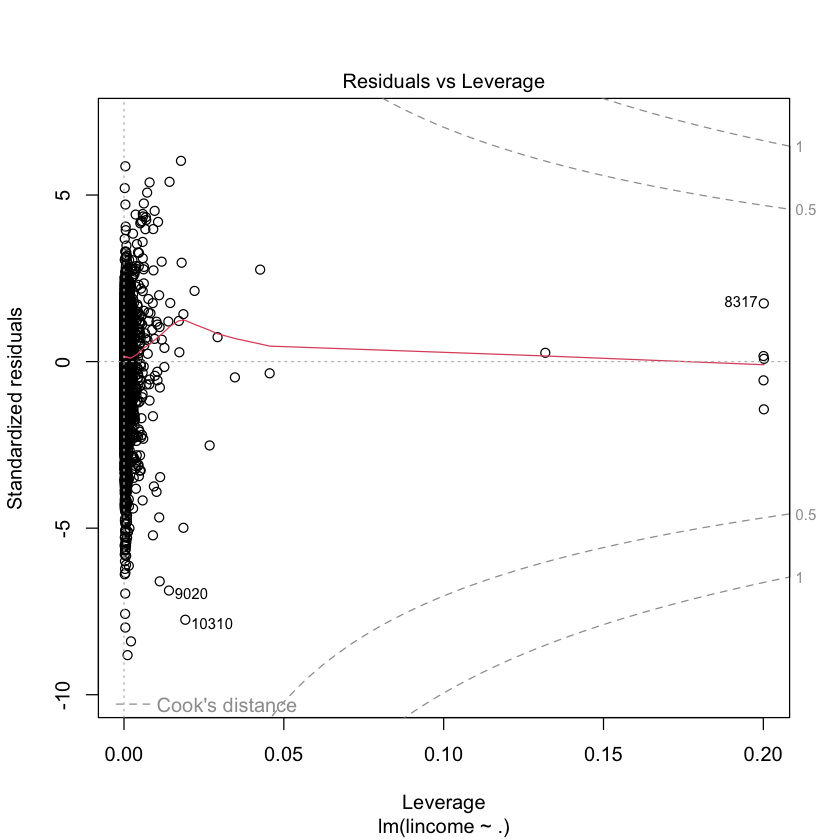

In [67]:
# =========== LINEAR REGRESSION ===========
m1 <- lm(lincome ~ ., data = data)
summary(m1)
plot(m1)

# !!!!!! The diagnostic plots show any significant problems with the model fit !!!!!!

In [ ]:
# =========== SIMUALTIONS ===========